Pump it Up: Data Mining the Water Table from drivendata.com
In this project I used Optuna & XGBoost with multiple boosters to achieve a score of 0.6621.
CURRENT RANK 4841st out of 13922 competitors


In [1]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
train_values = pd.read_csv('train_values.csv', index_col='id')
train_labels = pd.read_csv('train_labels.csv', index_col='id')

In [3]:
import seaborn as sns

<AxesSubplot:xlabel='index'>

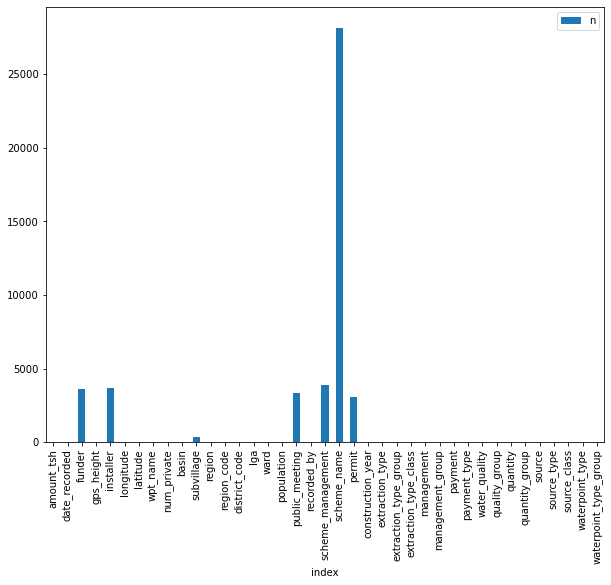

In [4]:
train_values.isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=90, figsize=(10, 8))


In [5]:
df = pd.merge(train_values, train_labels, how='outer', left_on = 'id', right_on = 'id')

In [6]:
df.index.nunique()


59400

In [7]:
df.num_private.nunique()

65

In [8]:
for col in ['funder', 'installer', 'wpt_name', 'basin','subvillage','region','lga','ward','recorded_by','scheme_management']:
    df[col] = df[col].astype('category')

In [9]:
df = df.drop(['extraction_type_class', 'extraction_type_group', 'payment', 'quantity_group','source_type','waterpoint_type_group'], axis=1)

In [10]:
df1 = df.pop('status_group')
df['status_group']=df1

In [11]:
for col in ['permit', 'public_meeting', 'extraction_type', 'management','management_group','payment_type','water_quality','quality_group','quantity','source','source_class','waterpoint_type','status_group']:
    df[col] = df[col].astype('category')

In [12]:
df = df.drop(['funder', 'installer', 'wpt_name', 'num_private','subvillage','region','region_code','lga','ward','population'], axis=1)

In [13]:
df = df.drop(['basin', 'recorded_by', 'scheme_management', 'management','management_group','payment_type','quality_group','source_class'], axis=1)

In [14]:
df = df.drop(['district_code'], axis=1)

In [15]:
pd.set_option('display.max_columns', None)
df.head(5)

,amount_tsh,date_recorded,gps_height,longitude,latitude,public_meeting,scheme_name,permit,construction_year,extraction_type,water_quality,quantity,source,waterpoint_type,status_group
id,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,1390,34.938093,-9.856322,True,Roman,False,1999,gravity,soft,enough,spring,communal standpipe,functional
8776,0.0,2013-03-06,1399,34.698766,-2.147466,NaN,NaN,True,2010,gravity,soft,insufficient,rainwater harvesting,communal standpipe,functional
34310,25.0,2013-02-25,686,37.460664,-3.821329,True,Nyumba ya mungu pipe scheme,True,2009,gravity,soft,enough,dam,communal standpipe multiple,functional
67743,0.0,2013-01-28,263,38.486161,-11.155298,True,NaN,True,1986,submersible,soft,dry,machine dbh,communal standpipe multiple,non functional
19728,0.0,2011-07-13,0,31.130847,-1.825359,True,NaN,True,0,gravity,soft,seasonal,rainwater harvesting,communal standpipe,functional


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   amount_tsh         59400 non-null  float64 
 1   date_recorded      59400 non-null  object  
 2   gps_height         59400 non-null  int64   
 3   longitude          59400 non-null  float64 
 4   latitude           59400 non-null  float64 
 5   public_meeting     56066 non-null  category
 6   scheme_name        31234 non-null  object  
 7   permit             56344 non-null  category
 8   construction_year  59400 non-null  int64   
 9   extraction_type    59400 non-null  category
 10  water_quality      59400 non-null  category
 11  quantity           59400 non-null  category
 12  source             59400 non-null  category
 13  waterpoint_type    59400 non-null  category
 14  status_group       59400 non-null  category
dtypes: category(8), float64(3), int64(2), object(2)
m

In [17]:
df.isnull().values.any()

True

In [18]:
df.isnull().sum().sum()

34556

<AxesSubplot:xlabel='index'>

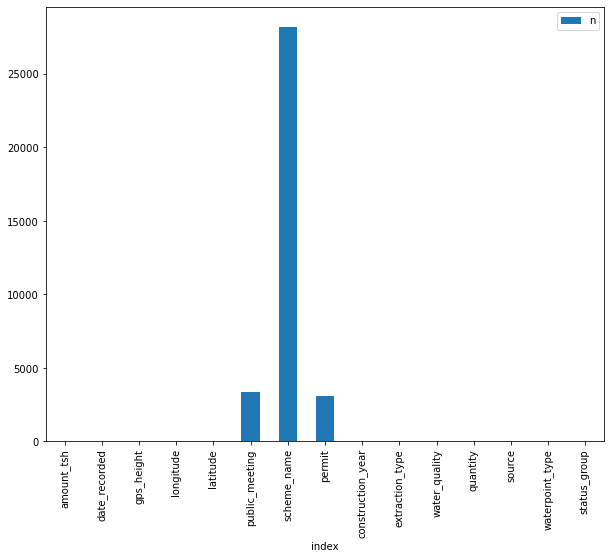

In [19]:
df.isna().sum().reset_index(name="n").plot.bar(x='index', y='n', rot=90, figsize=(10, 8))



In [20]:
for col in df.columns:
    print(df[col].isna().sum())
    


0
0
0
0
0
3334
28166
3056
0
0
0
0
0
0
0


In [21]:
mapping = {"functional":0,"functional needs repair":1, "non functional":2}

In [22]:
df['status_group'] = df['status_group'].map(mapping)


In [23]:
df.dropna(axis=0)

,amount_tsh,date_recorded,gps_height,longitude,latitude,public_meeting,scheme_name,permit,construction_year,extraction_type,water_quality,quantity,source,waterpoint_type,status_group
id,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,1390,34.938093,-9.856322,True,Roman,False,1999,gravity,soft,enough,spring,communal standpipe,0
34310,25.0,2013-02-25,686,37.460664,-3.821329,True,Nyumba ya mungu pipe scheme,True,2009,gravity,soft,enough,dam,communal standpipe multiple,0
9944,20.0,2011-03-13,0,39.172796,-4.765587,True,Zingibali,True,2009,submersible,salty,enough,other,communal standpipe multiple,0
50495,0.0,2013-03-15,1368,37.092574,-3.181783,True,BL Bondeni,True,2009,gravity,soft,enough,spring,communal standpipe,0
53752,0.0,2012-10-20,0,34.364073,-3.629333,True,None,True,0,nira/tanira,soft,enough,shallow well,hand pump,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67885,0.0,2011-03-16,0,38.835001,-4.880204,True,Magati water schem,True,1992,gravity,soft,insufficient,spring,communal standpipe,2
47002,6.0,2013-08-03,1383,37.454759,-3.323599,True,Kirua kahe gravity water supply trust,True,2008,gravity,soft,enough,spring,communal standpipe,2
44885,0.0,2013-08-03,540,38.044070,-4.272218,True,Hingilili,True,1967,gravity,soft,enough,river,communal standpipe,2


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   amount_tsh         59400 non-null  float64 
 1   date_recorded      59400 non-null  object  
 2   gps_height         59400 non-null  int64   
 3   longitude          59400 non-null  float64 
 4   latitude           59400 non-null  float64 
 5   public_meeting     56066 non-null  category
 6   scheme_name        31234 non-null  object  
 7   permit             56344 non-null  category
 8   construction_year  59400 non-null  int64   
 9   extraction_type    59400 non-null  category
 10  water_quality      59400 non-null  category
 11  quantity           59400 non-null  category
 12  source             59400 non-null  category
 13  waterpoint_type    59400 non-null  category
 14  status_group       59400 non-null  category
dtypes: category(8), float64(3), int64(2), object(2)
m

In [25]:
df_2 = pd.get_dummies(df, columns=['public_meeting', 'permit', 'extraction_type', 'water_quality', 'quantity', 'source','waterpoint_type'], drop_first=True)
df_2

,amount_tsh,date_recorded,gps_height,longitude,latitude,scheme_name,construction_year,status_group,public_meeting_True,permit_True,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,1390,34.938093,-9.856322,Roman,1999,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8776,0.0,2013-03-06,1399,34.698766,-2.147466,NaN,2010,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
34310,25.0,2013-02-25,686,37.460664,-3.821329,Nyumba ya mungu pipe scheme,2009,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
67743,0.0,2013-01-28,263,38.486161,-11.155298,NaN,1986,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
19728,0.0,2011-07-13,0,31.130847,-1.825359,NaN,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,2013-05-03,1210,37.169807,-3.253847,Losaa Kia water supply,1999,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
27263,4700.0,2011-05-07,1212,35.249991,-9.070629,Ikondo electrical water sch,1996,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
37057,0.0,2011-04-11,0,34.017087,-8.750434,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [26]:
df[['construction_year']].value_counts()

construction_year
0                    20709
2010                  2645
2008                  2613
2009                  2533
2000                  2091
2007                  1587
2006                  1471
2003                  1286
2011                  1256
2004                  1123
2012                  1084
2002                  1075
1978                  1037
1995                  1014
2005                  1011
1999                   979
1998                   966
1990                   954
1985                   945
1980                   811
1996                   811
1984                   779
1982                   744
1994                   738
1972                   708
1974                   676
1997                   644
1992                   640
1993                   608
2001                   540
1988                   521
1983                   488
1975                   437
1986                   434
1976                   414
1970                   411
1991      

In [27]:
df = df_2.drop(['amount_tsh', 'scheme_name','construction_year','gps_height','date_recorded'], axis=1)

In [28]:
df.head()

,longitude,latitude,status_group,public_meeting_True,permit_True,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,34.938093,-9.856322,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8776,34.698766,-2.147466,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
34310,37.460664,-3.821329,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
67743,38.486161,-11.155298,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
19728,31.130847,-1.825359,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [29]:
df = df.drop(['longitude'], axis=1)


In [30]:
from sklearn.preprocessing import StandardScaler
col_names = ['latitude']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [31]:
df.head()

,latitude,status_group,public_meeting_True,permit_True,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,-9.856322,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8776,-2.147466,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
34310,-3.821329,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
67743,-11.155298,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
19728,-1.825359,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [32]:
df1 = df.pop('status_group')
df['status_group']=df1

In [33]:
df.columns

Index(['latitude', 'public_meeting_True', 'permit_True',
       'extraction_type_cemo', 'extraction_type_climax',
       'extraction_type_gravity', 'extraction_type_india mark ii',
       'extraction_type_india mark iii', 'extraction_type_ksb',
       'extraction_type_mono', 'extraction_type_nira/tanira',
       'extraction_type_other', 'extraction_type_other - mkulima/shinyanga',
       'extraction_type_other - play pump',
       'extraction_type_other - rope pump', 'extraction_type_other - swn 81',
       'extraction_type_submersible', 'extraction_type_swn 80',
       'extraction_type_walimi', 'extraction_type_windmill',
       'water_quality_fluoride', 'water_quality_fluoride abandoned',
       'water_quality_milky', 'water_quality_salty',
       'water_quality_salty abandoned', 'water_quality_soft',
       'water_quality_unknown', 'quantity_enough', 'quantity_insufficient',
       'quantity_seasonal', 'quantity_unknown', 'source_hand dtw',
       'source_lake', 'source_machine dbh'

In [34]:
df.corrwith(df['status_group']).sort_values(ascending=False)

waterpoint_type_other                          0.310295
extraction_type_other                          0.295936
water_quality_unknown                          0.163276
waterpoint_type_communal standpipe multiple    0.114094
source_lake                                    0.086543
extraction_type_mono                           0.084968
source_shallow well                            0.074402
quantity_unknown                               0.073438
source_machine dbh                             0.068227
water_quality_salty                            0.062256
extraction_type_ksb                            0.024149
extraction_type_other - play pump              0.018522
extraction_type_climax                         0.016105
extraction_type_windmill                       0.011427
extraction_type_india mark iii                 0.010729
quantity_insufficient                          0.010173
water_quality_fluoride abandoned               0.008069
extraction_type_other - mkulima/shinyanga      0

In [35]:
final_df = df[['waterpoint_type_other',
'extraction_type_other',
'water_quality_unknown',
'waterpoint_type_communal standpipe multiple',
'source_lake',
'extraction_type_mono',
'waterpoint_type_hand pump',                   
'source_spring',                   
'water_quality_soft',                            
'extraction_type_gravity',
'waterpoint_type_communal standpipe',
'quantity_enough',
'status_group']].copy()
final_df.columns

Index(['waterpoint_type_other', 'extraction_type_other',
       'water_quality_unknown', 'waterpoint_type_communal standpipe multiple',
       'source_lake', 'extraction_type_mono', 'waterpoint_type_hand pump',
       'source_spring', 'water_quality_soft', 'extraction_type_gravity',
       'waterpoint_type_communal standpipe', 'quantity_enough',
       'status_group'],
      dtype='object')

In [36]:
final_df.columns

Index(['waterpoint_type_other', 'extraction_type_other',
       'water_quality_unknown', 'waterpoint_type_communal standpipe multiple',
       'source_lake', 'extraction_type_mono', 'waterpoint_type_hand pump',
       'source_spring', 'water_quality_soft', 'extraction_type_gravity',
       'waterpoint_type_communal standpipe', 'quantity_enough',
       'status_group'],
      dtype='object')

In [37]:
x = final_df.iloc[:, :-1]
y = final_df['status_group']
x.columns


Index(['waterpoint_type_other', 'extraction_type_other',
       'water_quality_unknown', 'waterpoint_type_communal standpipe multiple',
       'source_lake', 'extraction_type_mono', 'waterpoint_type_hand pump',
       'source_spring', 'water_quality_soft', 'extraction_type_gravity',
       'waterpoint_type_communal standpipe', 'quantity_enough'],
      dtype='object')

In [38]:
%%time
import optuna

import sklearn.datasets
from sklearn.model_selection import train_test_split
import sklearn.metrics
import xgboost as xgb


def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "num_class": 3,
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-07-28 19:58:36,659] A new study created in memory with name: no-name-93409ed0-7c44-4c90-8077-318c8d1cff03


[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes

[I 2022-07-28 19:58:37,059] Trial 0 finished with value: 0.6565656565656566 and parameters: {'booster': 'dart', 'lambda': 1.1030227266506401e-05, 'alpha': 1.2954848847557656e-07, 'subsample': 0.423051741078191, 'colsample_bytree': 0.3348701682976146, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.30125260648728125, 'gamma': 1.441690837501415e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0007136513207866122, 'skip_drop': 1.0647381230119273e-06}. Best is trial 0 with value: 0.6565656565656566.


[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:58:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes

[I 2022-07-28 19:58:37,647] Trial 1 finished with value: 0.6616161616161617 and parameters: {'booster': 'gbtree', 'lambda': 7.139309675889567e-07, 'alpha': 0.0358898625184654, 'subsample': 0.4663749896115425, 'colsample_bytree': 0.7212060031209562, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.8716112158466086, 'gamma': 0.017589963815140795, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6616161616161617.


[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=5
[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=5
[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:38,111] Trial 2 finished with value: 0.6583164983164983 and parameters: {'booster': 'gbtree', 'lambda': 0.00014157041850716503, 'alpha': 3.27283070896643e-07, 'subsample': 0.26041436286349573, 'colsample_bytree': 0.6954799007531784, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.018497347662450127, 'gamma': 7.448682408374896e-08, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6616161616161617.


[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[19:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:38,443] Trial 3 finished with value: 0.6494949494949495 and parameters: {'booster': 'gbtree', 'lambda': 0.07811853813759286, 'alpha': 0.14702510888876427, 'subsample': 0.8015880626916294, 'colsample_bytree': 0.6657284656284946, 'max_depth': 3, 'min_child_weight': 7, 'eta': 0.003308325950542501, 'gamma': 0.058025645513515044, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6616161616161617.


[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=6
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=6
[19:58:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 2 pruned nodes, max_

[I 2022-07-28 19:58:39,061] Trial 4 finished with value: 0.6566329966329967 and parameters: {'booster': 'gbtree', 'lambda': 1.8350377512799937e-08, 'alpha': 0.000356452377072585, 'subsample': 0.6547522098064178, 'colsample_bytree': 0.575733541633624, 'max_depth': 7, 'min_child_weight': 3, 'eta': 1.3778928168915373e-06, 'gamma': 0.048303825590790904, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6616161616161617.


[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 8 pruned nodes, max_depth=6
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 4 pruned nodes, max_depth=6
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[19:58:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=7
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 2 pruned nodes, max_depth=7
[19:58:39] src/gbm/gbtree.cc:494: drop 0 tree

[I 2022-07-28 19:58:39,604] Trial 5 finished with value: 0.6468013468013468 and parameters: {'booster': 'dart', 'lambda': 0.02495755670258611, 'alpha': 0.013763636284306477, 'subsample': 0.20349765996320546, 'colsample_bytree': 0.6207550866972411, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.0007599516518569498, 'gamma': 0.004744795388155759, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.622642613556419e-06, 'skip_drop': 0.2998514532043485}. Best is trial 1 with value: 0.6616161616161617.


[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=6
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[19:58:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 2 pruned nodes, max_depth=7
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=7
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[19:58:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes

[I 2022-07-28 19:58:39,690] Trial 6 finished with value: 0.658047138047138 and parameters: {'booster': 'gblinear', 'lambda': 0.00017024437039183028, 'alpha': 8.898549731211944e-08, 'subsample': 0.8317206294661681, 'colsample_bytree': 0.797678432231054}. Best is trial 1 with value: 0.6616161616161617.


[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes

[I 2022-07-28 19:58:40,027] Trial 7 finished with value: 0.6449158249158249 and parameters: {'booster': 'dart', 'lambda': 4.002338674728891e-06, 'alpha': 3.5009922577841135e-07, 'subsample': 0.35602281455954093, 'colsample_bytree': 0.5065952008299595, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.05385341419278396, 'gamma': 0.0009751044124055479, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.001683754385555266, 'skip_drop': 2.7738804316980255e-06}. Best is trial 1 with value: 0.6616161616161617.


[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes

[I 2022-07-28 19:58:40,529] Trial 8 finished with value: 0.6375084175084175 and parameters: {'booster': 'dart', 'lambda': 0.0012221603822871745, 'alpha': 1.776088941844297e-07, 'subsample': 0.474243941081355, 'colsample_bytree': 0.9215354499475357, 'max_depth': 3, 'min_child_weight': 10, 'eta': 2.688452730066436e-06, 'gamma': 0.0005357446763976486, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.3955577140872794e-05, 'skip_drop': 0.0002637518184866415}. Best is trial 1 with value: 0.6616161616161617.


[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes

[I 2022-07-28 19:58:40,937] Trial 9 finished with value: 0.6466666666666666 and parameters: {'booster': 'dart', 'lambda': 3.8578138367358386e-05, 'alpha': 7.367837718454571e-08, 'subsample': 0.7177056285341425, 'colsample_bytree': 0.39929200234360307, 'max_depth': 9, 'min_child_weight': 3, 'eta': 4.4250609382225196e-07, 'gamma': 0.0023772412296666568, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.5811661113537878e-05, 'skip_drop': 1.4366790875424517e-08}. Best is trial 1 with value: 0.6616161616161617.


[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[19:58:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:58:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[19:58:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes

[I 2022-07-28 19:58:41,033] Trial 10 finished with value: 0.6520538720538721 and parameters: {'booster': 'gblinear', 'lambda': 8.61622266113998e-08, 'alpha': 0.0007781457070474575, 'subsample': 0.542437330132959, 'colsample_bytree': 0.21802424681879}. Best is trial 1 with value: 0.6616161616161617.


[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:41,497] Trial 11 finished with value: 0.6691582491582492 and parameters: {'booster': 'gbtree', 'lambda': 6.858722248433078e-07, 'alpha': 1.6004225575042862e-05, 'subsample': 0.2082373956930509, 'colsample_bytree': 0.7807650296304279, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.7264888433713893, 'gamma': 8.45969743946451e-07, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:42,099] Trial 12 finished with value: 0.6662626262626262 and parameters: {'booster': 'gbtree', 'lambda': 6.974640032891082e-07, 'alpha': 1.2132916965347655e-05, 'subsample': 0.3354927736029517, 'colsample_bytree': 0.8823762487402667, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.6475388093846138, 'gamma': 5.370529808698794e-06, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[19:58:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:58:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:58:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:58:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:58:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=7
[19:58:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[19:58:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, ma

[I 2022-07-28 19:58:43,054] Trial 13 finished with value: 0.655959595959596 and parameters: {'booster': 'gbtree', 'lambda': 3.7255284644048253e-07, 'alpha': 1.2920981438997009e-05, 'subsample': 0.969346865788607, 'colsample_bytree': 0.9923288729184885, 'max_depth': 7, 'min_child_weight': 5, 'eta': 1.449300592741294e-08, 'gamma': 3.546383499466734e-06, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:43,657] Trial 14 finished with value: 0.6534006734006734 and parameters: {'booster': 'gbtree', 'lambda': 1.2412299846290243e-08, 'alpha': 1.683020667299062e-05, 'subsample': 0.3268649042936698, 'colsample_bytree': 0.8434457483372373, 'max_depth': 5, 'min_child_weight': 5, 'eta': 8.552380112124244e-05, 'gamma': 5.144922156404757e-06, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[19:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:44,340] Trial 15 finished with value: 0.6626262626262627 and parameters: {'booster': 'gbtree', 'lambda': 1.4059366144879636e-06, 'alpha': 1.4043373553223467e-05, 'subsample': 0.21526524979000072, 'colsample_bytree': 0.8259917321806742, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.9446591564965107, 'gamma': 1.055646635297754e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=7
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:44,990] Trial 16 finished with value: 0.6541414141414141 and parameters: {'booster': 'gbtree', 'lambda': 1.7505900774906089e-07, 'alpha': 4.288673710015498e-06, 'subsample': 0.3420057332662813, 'colsample_bytree': 0.9984376529084779, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.02469729765514749, 'gamma': 2.1019526132809914e-07, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:45,083] Trial 17 finished with value: 0.6541414141414141 and parameters: {'booster': 'gblinear', 'lambda': 1.102392496258493e-05, 'alpha': 0.0025795562034212965, 'subsample': 0.5731698574619739, 'colsample_bytree': 0.8964957614706106}. Best is trial 11 with value: 0.6691582491582492.


[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:45,810] Trial 18 finished with value: 0.6562962962962963 and parameters: {'booster': 'gbtree', 'lambda': 7.350131485753763e-08, 'alpha': 2.3435934652833984e-06, 'subsample': 0.29412983630602996, 'colsample_bytree': 0.7677009591000832, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.00011810882951897613, 'gamma': 5.649381232040878e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[I 2022-07-28 19:58:46,153] Trial 19 finished with value: 0.6479461279461279 and parameters: {'booster': 'gbtree', 'lambda': 0.8955281360342877, 'alpha': 1.1462845521116972e-08, 'subsample': 0.406969454288536, 'colsample_bytree': 0.5316014884576789, 'max_depth': 3, 'min_child_weight': 7, 'eta': 0.06948306020568913, 'gamma': 6.02219454773457e-07, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:46,248] Trial 20 finished with value: 0.6471380471380471 and parameters: {'booster': 'gblinear', 'lambda': 0.00040263564988473634, 'alpha': 0.0001775022308488568, 'subsample': 0.5071839666921967, 'colsample_bytree': 0.9275058204743971}. Best is trial 11 with value: 0.6691582491582492.


[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=9
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:47,004] Trial 21 finished with value: 0.6601346801346801 and parameters: {'booster': 'gbtree', 'lambda': 1.980420724220744e-06, 'alpha': 4.0971160541739914e-05, 'subsample': 0.23484192177345498, 'colsample_bytree': 0.8457902003640675, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.9007071845998594, 'gamma': 2.0817127529641365e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 2 pruned nodes, max_depth=9
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[19:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=8
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:47,707] Trial 22 finished with value: 0.6614814814814814 and parameters: {'booster': 'gbtree', 'lambda': 1.1787283603284559e-06, 'alpha': 2.3315560410636104e-06, 'subsample': 0.21368892402168033, 'colsample_bytree': 0.7697323786240889, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.15478754787904217, 'gamma': 1.920085294491567e-06, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=9
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 10 pruned nodes, max_depth=5
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=5
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=5
[19:58:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 4 pruned nodes, ma

[I 2022-07-28 19:58:48,279] Trial 23 finished with value: 0.6613468013468013 and parameters: {'booster': 'gbtree', 'lambda': 1.8048382551395103e-05, 'alpha': 0.00010288987775828698, 'subsample': 0.30648502115154364, 'colsample_bytree': 0.8470533608976892, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.005097384867653836, 'gamma': 0.8832088780638391, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 14 pruned nodes, max_depth=5
[19:58:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 22 pruned nodes, max_depth=5
[19:58:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 2 pruned nodes, max_depth=5
[19:58:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[19:58:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[19:58:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[19:58:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[19:58:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[19:58:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, ma

[I 2022-07-28 19:58:49,096] Trial 24 finished with value: 0.6642424242424242 and parameters: {'booster': 'gbtree', 'lambda': 2.938231893317377e-06, 'alpha': 8.490852302154319e-06, 'subsample': 0.39861119147540525, 'colsample_bytree': 0.7590351435722962, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.2502778573191126, 'gamma': 1.9140099273577226e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=7
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=7
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=7
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=7
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:49,846] Trial 25 finished with value: 0.66 and parameters: {'booster': 'gbtree', 'lambda': 4.590697651207247e-06, 'alpha': 9.71877039667981e-07, 'subsample': 0.3888356958737742, 'colsample_bytree': 0.7345108025153815, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.006581971719287119, 'gamma': 0.00014630337823103463, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 2 pruned nodes, max_depth=7
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:50,307] Trial 26 finished with value: 0.6526599326599326 and parameters: {'booster': 'gbtree', 'lambda': 4.876235523177916e-08, 'alpha': 0.0020522363873880243, 'subsample': 0.29357660373367406, 'colsample_bytree': 0.6361089069950412, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.12055981623275693, 'gamma': 8.433818635467537e-07, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[19:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[19:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[19:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max

[I 2022-07-28 19:58:51,268] Trial 27 finished with value: 0.6578451178451179 and parameters: {'booster': 'gbtree', 'lambda': 3.6204342267552037e-07, 'alpha': 6.575453702305811e-06, 'subsample': 0.6411566861630231, 'colsample_bytree': 0.9061898025201652, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.0003576739403482239, 'gamma': 4.54690133318764e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max

[I 2022-07-28 19:58:51,863] Trial 28 finished with value: 0.655959595959596 and parameters: {'booster': 'gbtree', 'lambda': 0.0024393510429082245, 'alpha': 5.251929933772158e-05, 'subsample': 0.44044989171256044, 'colsample_bytree': 0.6957779636663485, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.20001112754395156, 'gamma': 6.738726837641109e-08, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:51,957] Trial 29 finished with value: 0.648013468013468 and parameters: {'booster': 'gblinear', 'lambda': 4.2061504877303026e-05, 'alpha': 1.0690269514216268e-06, 'subsample': 0.3950341626131461, 'colsample_bytree': 0.7632518282523568}. Best is trial 11 with value: 0.6691582491582492.


[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[19:58:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[19:58:52] src/gbm/gbtree.cc:494: drop 2 trees, weight = 0.999994
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned

[I 2022-07-28 19:58:52,382] Trial 30 finished with value: 0.6486868686868686 and parameters: {'booster': 'dart', 'lambda': 1.0380020617013151e-05, 'alpha': 0.783276467637936, 'subsample': 0.36698251204208343, 'colsample_bytree': 0.4287515363729909, 'max_depth': 7, 'min_child_weight': 6, 'eta': 1.8270230782893395e-05, 'gamma': 0.0002494443675146627, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.7466068574922745, 'skip_drop': 0.6025295143405832}. Best is trial 11 with value: 0.6691582491582492.


[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[19:58:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[19:58:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:58:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:58:52] src/gbm/gbtree.cc:494: drop 16 trees, weight = 0.999994
[19:58:52] src/tree/updater_prune

[I 2022-07-28 19:58:53,124] Trial 31 finished with value: 0.6638383838383838 and parameters: {'booster': 'gbtree', 'lambda': 2.5546994965002608e-06, 'alpha': 2.374926718253816e-05, 'subsample': 0.26208101329151345, 'colsample_bytree': 0.8325435525966121, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.8147757197428305, 'gamma': 7.637402059782484e-06, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=8
[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=9
[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max

[I 2022-07-28 19:58:53,953] Trial 32 finished with value: 0.6662626262626262 and parameters: {'booster': 'gbtree', 'lambda': 2.774565712001054e-07, 'alpha': 4.135821616262309e-05, 'subsample': 0.2587124829795201, 'colsample_bytree': 0.8877240805870752, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.3277303963401324, 'gamma': 2.0667807648633272e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=9
[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=9
[19:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:54,508] Trial 33 finished with value: 0.6617508417508418 and parameters: {'booster': 'gbtree', 'lambda': 4.961316241660117e-07, 'alpha': 0.00021964066921619497, 'subsample': 0.2700434470009728, 'colsample_bytree': 0.8926305356522528, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.030293904958828142, 'gamma': 9.084986737574123e-07, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:58:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:58:55,753] Trial 34 finished with value: 0.6644444444444444 and parameters: {'booster': 'gbtree', 'lambda': 1.9938414570899472e-07, 'alpha': 6.558779001742468e-05, 'subsample': 0.45596610161454143, 'colsample_bytree': 0.9719260264479278, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.24941855201746865, 'gamma': 3.148303658687371e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[19:58:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=9
[19:58:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[19:58:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[19:58:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[19:58:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[19:58:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[19:58:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[19:58:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nod

[I 2022-07-28 19:58:57,010] Trial 35 finished with value: 0.6657239057239057 and parameters: {'booster': 'gbtree', 'lambda': 3.371257231819042e-08, 'alpha': 0.0006980483802885881, 'subsample': 0.46303152176912155, 'colsample_bytree': 0.9575605412615334, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.30784677169254715, 'gamma': 2.525113574352446e-08, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[19:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[19:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[19:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=9
[19:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[19:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[19:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[19:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[19:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned no

[I 2022-07-28 19:58:58,327] Trial 36 finished with value: 0.6587205387205387 and parameters: {'booster': 'gbtree', 'lambda': 2.5107791720662982e-08, 'alpha': 0.0008274324750533829, 'subsample': 0.5039780310452698, 'colsample_bytree': 0.9538545808224452, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.011606655193220065, 'gamma': 1.2458423963598244e-08, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes,

[I 2022-07-28 19:58:58,883] Trial 37 finished with value: 0.6628282828282829 and parameters: {'booster': 'gbtree', 'lambda': 5.25033590216059e-08, 'alpha': 0.015431509228888486, 'subsample': 0.2566548897906074, 'colsample_bytree': 0.864408721354025, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.0014597136612940016, 'gamma': 5.867738550601878e-08, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[19:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[19:58:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max

[I 2022-07-28 19:58:59,908] Trial 38 finished with value: 0.6597979797979798 and parameters: {'booster': 'gbtree', 'lambda': 1.7214049109351928e-07, 'alpha': 0.003689872166787086, 'subsample': 0.32372030554900616, 'colsample_bytree': 0.953855627759132, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.41528169907803514, 'gamma': 2.1160108198676534e-07, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:58:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:58:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:58:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:58:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes

[I 2022-07-28 19:59:00,245] Trial 39 finished with value: 0.6478787878787878 and parameters: {'booster': 'dart', 'lambda': 1.1753379839317075e-08, 'alpha': 0.0004953757474666248, 'subsample': 0.20198038546162841, 'colsample_bytree': 0.709327558696875, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.06992527880941136, 'gamma': 3.540400762185876e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.514189152017115e-08, 'skip_drop': 0.0007818415001534821}. Best is trial 11 with value: 0.6691582491582492.


[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:59:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes

[I 2022-07-28 19:59:00,834] Trial 40 finished with value: 0.6581818181818182 and parameters: {'booster': 'gbtree', 'lambda': 7.018737456706856e-07, 'alpha': 0.00013993017242212126, 'subsample': 0.3558308734625328, 'colsample_bytree': 0.806517943351698, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.01882017052828134, 'gamma': 1.3390701437135423e-07, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[19:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[19:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[19:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 2 pruned nodes, max_depth=9
[19:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[19:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes

[I 2022-07-28 19:59:02,068] Trial 41 finished with value: 0.6662626262626262 and parameters: {'booster': 'gbtree', 'lambda': 1.2347638744810588e-07, 'alpha': 4.5525199549046085e-05, 'subsample': 0.4494118078640492, 'colsample_bytree': 0.9582794687245799, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.31318298108571363, 'gamma': 3.910514347217304e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=9
[19:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[19:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[19:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[19:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[19:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[19:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[19:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[19:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned node

[I 2022-07-28 19:59:03,335] Trial 42 finished with value: 0.6638383838383838 and parameters: {'booster': 'gbtree', 'lambda': 9.65316934963537e-08, 'alpha': 3.3766459701414354e-05, 'subsample': 0.4847948993342314, 'colsample_bytree': 0.9374902215524424, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.3876030428286412, 'gamma': 2.3156906106027628e-06, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[19:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[19:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[19:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[19:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[19:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[19:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[19:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[19:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nod

[I 2022-07-28 19:59:04,555] Trial 43 finished with value: 0.6577777777777778 and parameters: {'booster': 'gbtree', 'lambda': 2.5571259351039095e-08, 'alpha': 0.00036811227906326, 'subsample': 0.559202068689691, 'colsample_bytree': 0.8849469457676769, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.09028269481511333, 'gamma': 8.799173908777586e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[19:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=9
[19:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[19:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[19:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[19:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[19:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[19:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[19:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned no

[I 2022-07-28 19:59:05,778] Trial 44 finished with value: 0.6653198653198653 and parameters: {'booster': 'gbtree', 'lambda': 2.715434239379846e-07, 'alpha': 8.528248903375262e-05, 'subsample': 0.4326824289733128, 'colsample_bytree': 0.9625395710184877, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.42672295430146834, 'gamma': 5.048300351323342e-07, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[19:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[19:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[19:59:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=7
[19:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[19:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=7
[19:59:06] src/gbm/gbtree.cc:494: drop 1 trees, weight = 0.985677
[19:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=7
[19:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 p

[I 2022-07-28 19:59:06,812] Trial 45 finished with value: 0.6639057239057239 and parameters: {'booster': 'dart', 'lambda': 8.238438850818742e-07, 'alpha': 3.2894667663897007e-06, 'subsample': 0.6484289530469887, 'colsample_bytree': 0.8786466642868541, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.043593549623531416, 'gamma': 1.0751602044496961e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.17925385367166805, 'skip_drop': 0.0030652799058076474}. Best is trial 11 with value: 0.6691582491582492.
[I 2022-07-28 19:59:06,907] Trial 46 finished with value: 0.6542760942760942 and parameters: {'booster': 'gblinear', 'lambda': 3.134484556083919e-08, 'alpha': 7.744374417983271e-07, 'subsample': 0.733995510160112, 'colsample_bytree': 0.6570134575982098}. Best is trial 11 with value: 0.6691582491582492.


[19:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[19:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=7
[19:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=7
[19:59:06] src/gbm/gbtree.cc:494: drop 5 trees, weight = 0.985677
[19:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[19:59:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 2 pruned nodes, max_depth=9
[19:59:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=9
[19:59:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[19:59:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 2 pruned nodes, max_depth=9
[19:59:07] src/tree/updater_prune

[I 2022-07-28 19:59:08,152] Trial 47 finished with value: 0.6668686868686868 and parameters: {'booster': 'gbtree', 'lambda': 1.125111257290913e-07, 'alpha': 0.007236159107918316, 'subsample': 0.5231721629375318, 'colsample_bytree': 0.9899004567425639, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.9279589725028059, 'gamma': 0.0004420350623002302, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:08,636] Trial 48 finished with value: 0.6567676767676768 and parameters: {'booster': 'gbtree', 'lambda': 1.2056188289005255e-07, 'alpha': 0.06519098526038065, 'subsample': 0.5372211504127294, 'colsample_bytree': 0.9992025943138032, 'max_depth': 3, 'min_child_weight': 7, 'eta': 0.9907114080417675, 'gamma': 0.0003666811528893819, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 2 pruned nodes, max_depth=7
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[19:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max

[I 2022-07-28 19:59:09,537] Trial 49 finished with value: 0.6607407407407407 and parameters: {'booster': 'gbtree', 'lambda': 7.345949415907738e-06, 'alpha': 0.007166997542274527, 'subsample': 0.5968356560046657, 'colsample_bytree': 0.8061009056378302, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.09139791544973391, 'gamma': 0.0023818955118527275, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[19:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[19:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[19:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[19:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=7
[19:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[19:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 2 pruned nodes, max_depth=7
[19:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:10,105] Trial 50 finished with value: 0.6537373737373737 and parameters: {'booster': 'gbtree', 'lambda': 5.120460103030502e-07, 'alpha': 1.7341865337310124e-05, 'subsample': 0.2498522159805198, 'colsample_bytree': 0.9195976618662554, 'max_depth': 5, 'min_child_weight': 2, 'eta': 2.6172535666960945e-08, 'gamma': 0.01164438756187617, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:59:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=5
[19:59:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=5
[19:59:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:59:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:59:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 2 pruned nodes, max_depth=5
[19:59:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[19:59:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=9
[19:59:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, ma

[I 2022-07-28 19:59:11,430] Trial 51 finished with value: 0.6592592592592592 and parameters: {'booster': 'gbtree', 'lambda': 3.9892533852941993e-08, 'alpha': 0.001094802898511772, 'subsample': 0.5168866248583773, 'colsample_bytree': 0.9670398128176911, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.40133839879267597, 'gamma': 0.0011567001612191187, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 6 pruned nodes, max_depth=9
[19:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=9
[19:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[19:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[19:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=9
[19:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[19:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[19:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=9
[19:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned node

[I 2022-07-28 19:59:12,527] Trial 52 finished with value: 0.6668013468013468 and parameters: {'booster': 'gbtree', 'lambda': 1.1973294089563616e-08, 'alpha': 0.007203340864554043, 'subsample': 0.941034548598198, 'colsample_bytree': 0.910532042917552, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.22287156237231048, 'gamma': 0.0001312854154174903, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[19:59:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=9
[19:59:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=9
[19:59:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=9
[19:59:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=9
[19:59:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[19:59:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[19:59:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[19:59:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes

[I 2022-07-28 19:59:13,548] Trial 53 finished with value: 0.6581818181818182 and parameters: {'booster': 'gbtree', 'lambda': 1.3362700414647667e-08, 'alpha': 0.24968503863922947, 'subsample': 0.994972196892245, 'colsample_bytree': 0.9086347286548371, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.13172781613300819, 'gamma': 0.00012123540848019174, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=9
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=

[I 2022-07-28 19:59:13,756] Trial 54 finished with value: 0.6483501683501683 and parameters: {'booster': 'gbtree', 'lambda': 9.437408724949862e-08, 'alpha': 0.022491952128144952, 'subsample': 0.8123686954772782, 'colsample_bytree': 0.23887271987299424, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.5424994731616491, 'gamma': 0.0007744567701463136, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.
[I 2022-07-28 19:59:13,833] Trial 55 finished with value: 0.5411447811447812 and parameters: {'booster': 'gblinear', 'lambda': 0.008257202846037006, 'alpha': 0.08794282387529861, 'subsample': 0.69600662833324, 'colsample_bytree': 0.8652051105435521}. Best is trial 11 with value: 0.6691582491582492.


[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[I 2022-07-28 19:59:15,049] Trial 56 finished with value: 0.6675420875420875 and parameters: {'booster': 'gbtree', 'lambda': 1.1518463111933856e-06, 'alpha': 0.007454631627980439, 'subsample': 0.8998770807106421, 'colsample_bytree': 0.9215507844883741, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.038782265341840816, 'gamma': 0.0002614586546230154, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[19:59:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[19:59:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=9
[19:59:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[19:59:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:59:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[19:59:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=9
[19:59:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=9
[19:59:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:59:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 prun

[I 2022-07-28 19:59:16,360] Trial 57 finished with value: 0.6646464646464646 and parameters: {'booster': 'dart', 'lambda': 1.2127278501974816e-06, 'alpha': 0.008040390801750775, 'subsample': 0.8999910719187811, 'colsample_bytree': 0.9350956720503482, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.0108108014101671, 'gamma': 0.00023299896402958977, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.3311548974744264e-08, 'skip_drop': 2.248725242415912e-08}. Best is trial 11 with value: 0.6691582491582492.


[19:59:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[19:59:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:59:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[19:59:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[19:59:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[19:59:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 2 pruned nodes, max_depth=9
[19:59:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[19:59:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=9
[19:59:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=9
[19:59:16] src/tree/updater_prune.cc:

[I 2022-07-28 19:59:17,577] Trial 58 finished with value: 0.6615488215488216 and parameters: {'booster': 'gbtree', 'lambda': 2.0211324765436837e-07, 'alpha': 0.0016267132513482754, 'subsample': 0.9014242720385496, 'colsample_bytree': 0.9995305692704959, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.04419043651186898, 'gamma': 0.0017632619149187912, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[19:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[19:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[19:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[19:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[19:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, m

[I 2022-07-28 19:59:18,180] Trial 59 finished with value: 0.6575084175084175 and parameters: {'booster': 'gbtree', 'lambda': 2.0685190007195788e-05, 'alpha': 0.005761454412624452, 'subsample': 0.8931270363915519, 'colsample_bytree': 0.7928169059105656, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.0022341678582667745, 'gamma': 3.797963142229297e-06, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=7
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 2 pruned nodes, max_depth=7
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=7
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_

[I 2022-07-28 19:59:18,893] Trial 60 finished with value: 0.6665319865319865 and parameters: {'booster': 'gbtree', 'lambda': 1.0480662077977676e-08, 'alpha': 0.03501890702579531, 'subsample': 0.9391916976568405, 'colsample_bytree': 0.5978107676990896, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.24687670880393137, 'gamma': 0.00845701064364318, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=7
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=7
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 8 pruned nodes, max_depth=7
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 2 pruned nodes, max_depth=7
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=7
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[19:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:19,471] Trial 61 finished with value: 0.6618855218855219 and parameters: {'booster': 'gbtree', 'lambda': 1.178307532880226e-08, 'alpha': 0.04977394838042043, 'subsample': 0.8514601016244108, 'colsample_bytree': 0.5806922673822263, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.1842249517455409, 'gamma': 0.0058709535582224595, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[19:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[19:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[19:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[19:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=6
[19:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[19:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 2 pruned nodes, max_depth=6
[19:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 6 pruned nodes, max_

[I 2022-07-28 19:59:20,036] Trial 62 finished with value: 0.6681481481481482 and parameters: {'booster': 'gbtree', 'lambda': 7.042146210521331e-08, 'alpha': 0.02560515067981914, 'subsample': 0.941358010053097, 'colsample_bytree': 0.500043801067707, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.9786617703893425, 'gamma': 0.06242418389386494, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 6 pruned nodes, max_depth=5
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 2 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_

[I 2022-07-28 19:59:20,593] Trial 63 finished with value: 0.6663973063973064 and parameters: {'booster': 'gbtree', 'lambda': 6.943907461549605e-08, 'alpha': 0.2038714650626215, 'subsample': 0.9625623466296864, 'colsample_bytree': 0.5447307914250533, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.6113884825986282, 'gamma': 0.05759285511306731, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=5
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 4 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 10 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=6
[19:59:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max

[I 2022-07-28 19:59:21,147] Trial 64 finished with value: 0.6628282828282829 and parameters: {'booster': 'gbtree', 'lambda': 2.0453966011121028e-08, 'alpha': 0.23723856846023933, 'subsample': 0.941742038673594, 'colsample_bytree': 0.5171636257019431, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.9308719316381662, 'gamma': 0.06604134145455298, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 8 pruned nodes, max_depth=6
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 14 pruned nodes, max_depth=6
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=6
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=6
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, ma

[I 2022-07-28 19:59:21,601] Trial 65 finished with value: 0.6615488215488216 and parameters: {'booster': 'gbtree', 'lambda': 1.7612150361236464e-08, 'alpha': 0.02676772969189438, 'subsample': 0.9419294501112048, 'colsample_bytree': 0.47608113468059926, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.1395565421657986, 'gamma': 0.18768068703888796, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=5
[19:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_

[I 2022-07-28 19:59:22,188] Trial 66 finished with value: 0.6554882154882155 and parameters: {'booster': 'gbtree', 'lambda': 6.688137437833032e-08, 'alpha': 0.012204542361725693, 'subsample': 0.9461175228978678, 'colsample_bytree': 0.543341211028256, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.04875820509272556, 'gamma': 0.02990779727413013, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.
[I 2022-07-28 19:59:22,264] Trial 67 finished with value: 0.5408754208754208 and parameters: {'booster': 'gblinear', 'lambda': 6.792415485111759e-08, 'alpha': 0.8320184903949337, 'subsample': 0.7683519737201913, 'colsample_bytree': 0.6139005384121374}. Best is trial 11 with value: 0.6691582491582492.


[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 2 pruned nodes, max_depth=6
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=6
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=5
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=5
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 10 pruned nodes, max

[I 2022-07-28 19:59:22,716] Trial 68 finished with value: 0.6612121212121213 and parameters: {'booster': 'gbtree', 'lambda': 0.17434624886619024, 'alpha': 0.11701130896012406, 'subsample': 0.860584285979119, 'colsample_bytree': 0.4828639673556082, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.5951840640083267, 'gamma': 0.2952865365775445, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 10 pruned nodes, max_depth=5
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=5
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=5
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=5
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=5
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max_depth=5
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max

[I 2022-07-28 19:59:23,057] Trial 69 finished with value: 0.6561616161616162 and parameters: {'booster': 'gbtree', 'lambda': 1.0005093902207837e-08, 'alpha': 0.2332255882028888, 'subsample': 0.9884182898982934, 'colsample_bytree': 0.40497888197500836, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.15089459943304268, 'gamma': 0.08055563129086085, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[19:59:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:23,654] Trial 70 finished with value: 0.6603367003367003 and parameters: {'booster': 'dart', 'lambda': 9.620187406483221e-05, 'alpha': 0.4605770498342307, 'subsample': 0.966453452356444, 'colsample_bytree': 0.5590423793719613, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.6156751455802545, 'gamma': 0.016502352955407674, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.017333592112496004, 'skip_drop': 0.011808881811761521}. Best is trial 11 with value: 0.6691582491582492.


[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 2 pruned nodes, max_depth=6
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=6
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 2 pruned nodes, max_depth=6
[19:59:23] src/gbm/gbtree.cc:494: drop 1 trees, weight = 0.829721
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=7
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 2 pruned nodes, max_depth=7
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[19:59:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[19:59:23] src/tree/updater_prune.cc:7

[I 2022-07-28 19:59:24,353] Trial 71 finished with value: 0.6573737373737374 and parameters: {'booster': 'gbtree', 'lambda': 1.0792910225785986e-07, 'alpha': 0.047748724387635666, 'subsample': 0.9201615019193734, 'colsample_bytree': 0.5890182908307047, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.21249469870803991, 'gamma': 0.005618855499995309, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=7
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 2 pruned nodes, max_depth=7
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 10 pruned nodes, max_depth=7
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 6 pruned nodes, max_depth=7
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 14 pruned nodes, max_depth=6
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 8 pruned nodes, ma

[I 2022-07-28 19:59:25,072] Trial 72 finished with value: 0.6628282828282829 and parameters: {'booster': 'gbtree', 'lambda': 2.6614737266561853e-07, 'alpha': 0.029731239526522346, 'subsample': 0.8699572755124902, 'colsample_bytree': 0.6437307283485537, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.989621985178624, 'gamma': 0.169641809743611, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 12 pruned nodes, max_depth=7
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 36 pruned nodes, max_depth=6
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 34 pruned nodes, max_depth=6
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=7
[19:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 18 pruned nodes, max_depth=6
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 24 pruned nodes, max_depth=7
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 22 pruned nodes, max_depth=6
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 36 pruned nodes, max_depth=6
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nod

[I 2022-07-28 19:59:25,530] Trial 73 finished with value: 0.661952861952862 and parameters: {'booster': 'gbtree', 'lambda': 3.6240719048198755e-08, 'alpha': 0.003920077148270314, 'subsample': 0.9275118479481618, 'colsample_bytree': 0.44954416000048447, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2856202999310759, 'gamma': 0.8079977484971932, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=4
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=5
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=5
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=5
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 6 pruned nodes, max_depth=5
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 14 pruned nodes, max_depth=5
[19:59:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes

[I 2022-07-28 19:59:26,433] Trial 74 finished with value: 0.6576430976430977 and parameters: {'booster': 'gbtree', 'lambda': 2.0045837176589264e-06, 'alpha': 0.011306036556164401, 'subsample': 0.9703727181261594, 'colsample_bytree': 0.6748493288114817, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.09312183544903896, 'gamma': 0.03784239653636848, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 2 pruned nodes, max_depth=8
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 6 pruned nodes, max_depth=8
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 8 pruned nodes, max_depth=8
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 6 pruned nodes, max_depth=8
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 10 pruned nodes, max_depth=8
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 10 pruned nodes, max_depth=8
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, ma

[I 2022-07-28 19:59:26,789] Trial 75 finished with value: 0.657979797979798 and parameters: {'booster': 'gbtree', 'lambda': 4.2043989991785843e-07, 'alpha': 0.019432316946585117, 'subsample': 0.8824733471333663, 'colsample_bytree': 0.36382549554583377, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.5173673751223946, 'gamma': 0.0005088851435524679, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[19:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:27,346] Trial 76 finished with value: 0.6567676767676768 and parameters: {'booster': 'gbtree', 'lambda': 7.875543455819109e-07, 'alpha': 6.027372923950315e-06, 'subsample': 0.835043900626013, 'colsample_bytree': 0.7448202705271284, 'max_depth': 5, 'min_child_weight': 4, 'eta': 8.262992080142285e-06, 'gamma': 0.011591549546989984, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 4 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:27,825] Trial 77 finished with value: 0.6534680134680134 and parameters: {'booster': 'gbtree', 'lambda': 5.553186182822283e-06, 'alpha': 0.0030722994645013373, 'subsample': 0.9612797546070662, 'colsample_bytree': 0.4842042837879162, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.0003517918242813207, 'gamma': 7.148418991766042e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[19:59:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:28,404] Trial 78 finished with value: 0.6548148148148148 and parameters: {'booster': 'gbtree', 'lambda': 4.902178078341343e-08, 'alpha': 0.12531823708375214, 'subsample': 0.7984589572460257, 'colsample_bytree': 0.5556594928733816, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.03126062236041905, 'gamma': 0.0002595707183870189, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[19:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[19:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[19:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=7
[19:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[19:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[19:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=7
[19:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=7
[19:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:29,152] Trial 79 finished with value: 0.6592592592592592 and parameters: {'booster': 'gbtree', 'lambda': 1.5221901908673364e-07, 'alpha': 0.04444974646176249, 'subsample': 0.5932432513924557, 'colsample_bytree': 0.6088199989582698, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.23232701426280133, 'gamma': 0.0026409690222782964, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=7
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=7
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=6
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=7
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=7
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 8 pruned nodes, max_depth=6
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 8 pruned nodes, max_

[I 2022-07-28 19:59:29,744] Trial 80 finished with value: 0.6541414141414141 and parameters: {'booster': 'gbtree', 'lambda': 1.9612347114687783e-08, 'alpha': 0.0016431384788358559, 'subsample': 0.9275983636147506, 'colsample_bytree': 0.522632222787282, 'max_depth': 9, 'min_child_weight': 8, 'eta': 3.78889411124122e-07, 'gamma': 0.12285160350168074, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=6
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=6
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 2 pruned nodes, max_depth=6
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 8 pruned nodes, max_depth=6
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 6 pruned nodes, max_depth=6
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:59:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:30,305] Trial 81 finished with value: 0.6677441077441078 and parameters: {'booster': 'gbtree', 'lambda': 3.273863684542805e-07, 'alpha': 9.96271667159407e-06, 'subsample': 0.2768908764264296, 'colsample_bytree': 0.8398930289018818, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.579694177049181, 'gamma': 2.0215336353117046e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:30,790] Trial 82 finished with value: 0.6602693602693602 and parameters: {'booster': 'gbtree', 'lambda': 3.3934489699768887e-07, 'alpha': 0.5045542478857772, 'subsample': 0.22163150572275137, 'colsample_bytree': 0.8564914709765808, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.5767986938412005, 'gamma': 2.278944975911624e-05, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.6691582491582492.


[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:59:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max

[I 2022-07-28 19:59:31,797] Trial 83 finished with value: 0.6692929292929293 and parameters: {'booster': 'gbtree', 'lambda': 6.960871875040399e-08, 'alpha': 9.44711069581822e-06, 'subsample': 0.29357293637184256, 'colsample_bytree': 0.9787116955257564, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.292851417720943, 'gamma': 0.00016321381948807066, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 0.6692929292929293.


[19:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=9
[19:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[19:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[19:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:59:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max

[I 2022-07-28 19:59:32,398] Trial 84 finished with value: 0.6538720538720538 and parameters: {'booster': 'gbtree', 'lambda': 7.301325888923376e-08, 'alpha': 1.1104645940821997e-05, 'subsample': 0.27385033817490484, 'colsample_bytree': 0.9858537290653979, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.06619998529522314, 'gamma': 0.00014896650501668436, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 0.6692929292929293.


[19:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 2 pruned nodes, max_depth=9
[19:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[19:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 2 pruned nodes, max_depth=9
[19:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 2 pruned nodes, max_depth=9
[19:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 10 pruned nodes, max_depth=9
[19:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 2 pruned nodes, max_depth=9
[19:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 4 pruned nodes, max_depth=9
[19:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 14 pruned nodes, max_depth=9
[19:59:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 2 pruned 

[I 2022-07-28 19:59:33,461] Trial 85 finished with value: 0.664040404040404 and parameters: {'booster': 'gbtree', 'lambda': 2.8683643664849735e-08, 'alpha': 3.954494721919608e-06, 'subsample': 0.31170193739728297, 'colsample_bytree': 0.9179575880505492, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.18571141548871015, 'gamma': 0.0007032276594555115, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 0.6692929292929293.


[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 4 pruned nodes, max_depth=9
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 8 pruned nodes, max_depth=9
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 2 pruned nodes, max_depth=9


[I 2022-07-28 19:59:33,559] Trial 86 finished with value: 0.64996632996633 and parameters: {'booster': 'gblinear', 'lambda': 5.099123233172993e-08, 'alpha': 1.5498849967504745e-06, 'subsample': 0.28729111607325886, 'colsample_bytree': 0.9427810816744487}. Best is trial 83 with value: 0.6692929292929293.


[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:33,937] Trial 87 finished with value: 0.6620875420875421 and parameters: {'booster': 'gbtree', 'lambda': 1.7432614883048357e-07, 'alpha': 0.011263819161044747, 'subsample': 0.9987763276708839, 'colsample_bytree': 0.8327758321738441, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.36153202613033486, 'gamma': 0.027730862310256565, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 0.6692929292929293.


[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:59:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:34,824] Trial 88 finished with value: 0.6598653198653198 and parameters: {'booster': 'gbtree', 'lambda': 1.8462850845931506e-08, 'alpha': 7.70125068167371e-06, 'subsample': 0.23467948106181025, 'colsample_bytree': 0.982756849414139, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.6043729748637052, 'gamma': 0.0013523517329247971, 'grow_policy': 'depthwise'}. Best is trial 83 with value: 0.6692929292929293.


[19:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=9
[19:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 2 pruned nodes, max_depth=9
[19:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=8
[19:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=9
[19:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 2 pruned nodes, max_depth=9
[19:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=9
[19:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[19:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 12 pruned nodes, max_depth=6
[19:59:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 24 pruned nodes, m

[I 2022-07-28 19:59:35,463] Trial 89 finished with value: 0.6523905723905724 and parameters: {'booster': 'dart', 'lambda': 1.3725990089268533e-06, 'alpha': 2.2019275354025466e-05, 'subsample': 0.914272418050937, 'colsample_bytree': 0.5087235382395517, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.11121652098230152, 'gamma': 0.4120656445929506, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.10826116196254e-07, 'skip_drop': 2.307627598884912e-06}. Best is trial 83 with value: 0.6692929292929293.


[19:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 6 pruned nodes, max_depth=6
[19:59:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 8 pruned nodes, max_depth=6
[19:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 28 pruned nodes, max_depth=6
[19:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 6 pruned nodes, max_depth=6
[19:59:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 10 pruned nodes, max_depth=6
[19:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 16 pruned nodes, max_depth=6
[19:59:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 22 pruned nodes, max_depth=6
[19:59:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[19:59:35] src/tree/updater_prune.c

[I 2022-07-28 19:59:36,182] Trial 90 finished with value: 0.6583164983164983 and parameters: {'booster': 'gbtree', 'lambda': 2.513970283573025e-07, 'alpha': 0.06526687814926774, 'subsample': 0.9767148748712108, 'colsample_bytree': 0.6310887027425636, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.2786983355050602, 'gamma': 0.0001769313725145841, 'grow_policy': 'lossguide'}. Best is trial 83 with value: 0.6692929292929293.


[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:36,774] Trial 91 finished with value: 0.673939393939394 and parameters: {'booster': 'gbtree', 'lambda': 5.084810508124239e-07, 'alpha': 1.2438665421344043e-05, 'subsample': 0.3312311601288346, 'colsample_bytree': 0.9015331764951454, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.6416238997805027, 'gamma': 1.005987095969487e-05, 'grow_policy': 'lossguide'}. Best is trial 91 with value: 0.673939393939394.


[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:59:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:37,374] Trial 92 finished with value: 0.6672727272727272 and parameters: {'booster': 'gbtree', 'lambda': 4.141572172102027e-07, 'alpha': 3.141977939215772e-05, 'subsample': 0.33785084652234343, 'colsample_bytree': 0.8973989678271609, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.8501002110894299, 'gamma': 8.611172707117643e-06, 'grow_policy': 'lossguide'}. Best is trial 91 with value: 0.673939393939394.


[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 2 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:38,009] Trial 93 finished with value: 0.662962962962963 and parameters: {'booster': 'gbtree', 'lambda': 5.481032262020154e-07, 'alpha': 2.5014855826521387e-05, 'subsample': 0.3601584877110094, 'colsample_bytree': 0.911690600789235, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.9878778331972374, 'gamma': 1.0505958003851177e-05, 'grow_policy': 'lossguide'}. Best is trial 91 with value: 0.673939393939394.


[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:38,621] Trial 94 finished with value: 0.6542760942760942 and parameters: {'booster': 'gbtree', 'lambda': 3.0946344962852974e-06, 'alpha': 1.0046952128989004e-05, 'subsample': 0.3223582155378765, 'colsample_bytree': 0.7870170398848341, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.3263370132838484, 'gamma': 1.6416742992124955e-06, 'grow_policy': 'lossguide'}. Best is trial 91 with value: 0.673939393939394.


[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:39,297] Trial 95 finished with value: 0.6615488215488216 and parameters: {'booster': 'gbtree', 'lambda': 9.326100210212989e-07, 'alpha': 7.623063656687341e-05, 'subsample': 0.38173419841565853, 'colsample_bytree': 0.8981325946875738, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.1899307006510479, 'gamma': 7.013648430474023e-05, 'grow_policy': 'lossguide'}. Best is trial 91 with value: 0.673939393939394.


[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:40,028] Trial 96 finished with value: 0.6651851851851852 and parameters: {'booster': 'gbtree', 'lambda': 1.3172270194951556e-07, 'alpha': 2.681935558211857e-06, 'subsample': 0.41932778813839544, 'colsample_bytree': 0.9337930333302724, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.4255897046621272, 'gamma': 6.452182446855758e-06, 'grow_policy': 'lossguide'}. Best is trial 91 with value: 0.673939393939394.


[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 2 pruned nodes, max_depth=5
[19:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:40,613] Trial 97 finished with value: 0.6635016835016835 and parameters: {'booster': 'gbtree', 'lambda': 1.89160284764239e-06, 'alpha': 0.00023132827116802506, 'subsample': 0.2864521919751144, 'colsample_bytree': 0.9728128918357115, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.6748754987743532, 'gamma': 3.599880130110298e-05, 'grow_policy': 'lossguide'}. Best is trial 91 with value: 0.673939393939394.


[19:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[19:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:41,139] Trial 98 finished with value: 0.656969696969697 and parameters: {'booster': 'gbtree', 'lambda': 5.728743553473728e-07, 'alpha': 5.014013943680335e-06, 'subsample': 0.24298317801858432, 'colsample_bytree': 0.863554862262266, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.10793649366770468, 'gamma': 1.093436091016028e-05, 'grow_policy': 'lossguide'}. Best is trial 91 with value: 0.673939393939394.


[19:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[19:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[19:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[19:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[19:59:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_

[I 2022-07-28 19:59:41,616] Trial 99 finished with value: 0.6597306397306397 and parameters: {'booster': 'gbtree', 'lambda': 0.00037298030627089485, 'alpha': 3.074293336885812e-07, 'subsample': 0.20863802829740175, 'colsample_bytree': 0.8166929590182623, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.06365211191201815, 'gamma': 0.00034484560614849173, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 0.673939393939394.


Number of finished trials:  100
Best trial:
  Value: 0.673939393939394
  Params: 
    booster: gbtree
    lambda: 5.084810508124239e-07
    alpha: 1.2438665421344043e-05
    subsample: 0.3312311601288346
    colsample_bytree: 0.9015331764951454
    max_depth: 5
    min_child_weight: 5
    eta: 0.6416238997805027
    gamma: 1.005987095969487e-05
    grow_policy: lossguide
CPU times: user 1min 5s, sys: 444 ms, total: 1min 5s
Wall time: 1min 5s


In [39]:
y_pred = pd.read_csv('test_values.csv', index_col='id')

In [40]:
y_pred = pd.get_dummies(y_pred, columns=['public_meeting', 'permit', 'extraction_type', 'water_quality', 'quantity', 'source','waterpoint_type'], drop_first=True)

from sklearn.preprocessing import StandardScaler
col_names = ['latitude']
features = y_pred[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [41]:
y_pred=y_pred[['waterpoint_type_other',
'extraction_type_other',
'water_quality_unknown',
'waterpoint_type_communal standpipe multiple',
'source_lake',
'extraction_type_mono',
'waterpoint_type_hand pump',                   
'source_spring',                   
'water_quality_soft',                            
'extraction_type_gravity',
'waterpoint_type_communal standpipe',
'quantity_enough']]
y_pred.head()

,waterpoint_type_other,extraction_type_other,water_quality_unknown,waterpoint_type_communal standpipe multiple,source_lake,extraction_type_mono,waterpoint_type_hand pump,source_spring,water_quality_soft,extraction_type_gravity,waterpoint_type_communal standpipe,quantity_enough
id,,,,,,,,,,,,
50785,1,1,0,0,0,0,0,0,1,0,0,0
51630,0,0,0,0,0,0,0,1,1,1,1,0
17168,1,1,0,0,0,0,0,0,1,0,0,0
45559,1,1,0,0,0,0,0,0,1,0,0,0
49871,0,0,0,0,0,0,0,1,1,1,1,1


In [42]:
from xgboost import XGBClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [43]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
# fit model no training data
model = XGBClassifier(booster='dart', random_state=2,
    alpha= 0.015212713744862437,
    subsample= 0.9739040521343817,
    colsample_bytree= 0.9328047815663402,
    max_depth= 9,
    min_child_weight= 3,
    eta= 0.9770502937394558,
    gamma= 0.002835645446754102,
    grow_policy= 'depthwise',
    sample_type= 'uniform',
    normalize_type= 'forest',
    rate_drop= 0.01002784479236407,
    skip_drop= 0.0012683803201724206)
model.fit(X_train, y_train)
# make predictions for test data
pred = model.predict(y_pred)
predictions = [value for value in y_pred]


In [55]:
pred[0:15]

array([2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0])

In [56]:
y_pred['status_group'] = pred.tolist()


In [96]:
y_pred.head(15)

,waterpoint_type_other,extraction_type_other,water_quality_unknown,waterpoint_type_communal standpipe multiple,source_lake,extraction_type_mono,waterpoint_type_hand pump,source_spring,water_quality_soft,extraction_type_gravity,waterpoint_type_communal standpipe,quantity_enough,status_group,id
id,,,,,,,,,,,,,,
50785,1,1,0,0,0,0,0,0,1,0,0,0,2,50785
51630,0,0,0,0,0,0,0,1,1,1,1,0,2,51630
17168,1,1,0,0,0,0,0,0,1,0,0,0,2,17168
45559,1,1,0,0,0,0,0,0,1,0,0,0,2,45559
49871,0,0,0,0,0,0,0,1,1,1,1,1,0,49871
52449,0,0,0,0,0,0,0,1,1,1,1,1,0,52449
24806,0,0,0,0,0,0,1,0,0,0,0,1,0,24806
28965,0,0,0,1,0,0,0,0,1,0,0,0,2,28965
36301,0,0,0,0,0,0,0,1,1,1,1,0,2,36301


In [97]:
last=y_pred['status_group']

In [109]:
f.to_csv('ok.csv')

In [108]:
f.head()

id
50785    2
51630    2
17168    2
45559    2
49871    0
Name: status_group, dtype: object

In [104]:
type(last)

pandas.core.series.Series

In [103]:
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 14 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   waterpoint_type_other                        14850 non-null  uint8 
 1   extraction_type_other                        14850 non-null  uint8 
 2   water_quality_unknown                        14850 non-null  uint8 
 3   waterpoint_type_communal standpipe multiple  14850 non-null  uint8 
 4   source_lake                                  14850 non-null  uint8 
 5   extraction_type_mono                         14850 non-null  uint8 
 6   waterpoint_type_hand pump                    14850 non-null  uint8 
 7   source_spring                                14850 non-null  uint8 
 8   water_quality_soft                           14850 non-null  uint8 
 9   extraction_type_gravity                      14850 non-null  uint8 
 10  waterp

In [105]:
last.to_frame()

,status_group
id,
50785,2
51630,2
17168,2
45559,2
49871,0
...,...
39307,0
18990,0
28749,0


In [106]:
hello = last.to_frame()

In [107]:
hello.to_csv('hi.csv')

In [111]:
mapping = {0:"functional",1:"functional needs repair", 2:"non functional"}
hello['status_group'] = hello['status_group'].map(mapping)



In [112]:
hello.to_csv('hi.csv')